# Regrid NorESM data to DGGS

## Description

The BLOM ocean data lives on a tripolar grid.  
This grid is irregular: An (x,y) grid with individual latitude and longitude values for each grid point. We can use x and y as indices.  
plat (2-dimensional, matches (x,y) grid) stores the latitude values of the points.  
x and y are simply dimensionless coordinates in the array to coordinate latitude, longitude, and temperature, which is stored as a 2D array of the same shape as (x,y).  
The example data in this notebook contains temperature at a single time point.  
We use netcdf functionality to regrid it to PlateCarree and then to xdggs.  

### This notebook step by step:

1. Load required libraries
2. Load sea surface temperature data on tripolar grid
3. Load regridded dataset with PlateCarree grid
4. Define new DGGS target grid
5. Regrid from PlateCarree to DGGS

## Contributions
- Even Moa Myklebust, Simula Research Laboratory (Norway) (author), @evenmm
- Anne Fouilloux, Simula Research Laboratory (Norway) (reviewer), @annefou
- Ola Formo Kihle, Independent Consultant / UW Contractor (Norway) (reviewer), @ofk123
- Yanchun He, NERSC (Norway) (provider of data and tutorial functions for loading data), @YanchunHe

## Bibliography and other interesting resources
- [The Norwegian Earth System Model (NorESM)](https://noresm-docs.readthedocs.io/en/latest/)
- [An introduction to NorESM model output and post-processing](https://nordicesmhub.github.io/noresmdiagnostics/)

## 1. Load required libraries

In [1]:
# Install xarray-healpy and dggs libraries for regridding
%pip install git+https://github.com/IAOCEA/xarray-healpy.git git+https://github.com/xarray-contrib/xdggs.git cmcrameri

  Cloning https://github.com/IAOCEA/xarray-healpy.git to /private/var/folders/_r/k7zwg4td0z54sgjlxsfx325m0000gn/T/pip-req-build-f5jq2a6h
  Running command git clone --filter=blob:none --quiet https://github.com/IAOCEA/xarray-healpy.git /private/var/folders/_r/k7zwg4td0z54sgjlxsfx325m0000gn/T/pip-req-build-f5jq2a6h
  Resolved https://github.com/IAOCEA/xarray-healpy.git to commit 5bc2b3a26537dbe8af850110223ceaf1c15b54d2
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Cloning https://github.com/xarray-contrib/xdggs.git to /private/var/folders/_r/k7zwg4td0z54sgjlxsfx325m0000gn/T/pip-req-build-u8uq9uh3
  Running command git clone --filter=blob:none --quiet https://github.com/xarray-contrib/xdggs.git /private/var/folders/_r/k7zwg4td0z54sgjlxsfx325m0000gn/T/pip-req-build-u8uq9uh3
  Resolved https://github.com/xarray-contrib/xdggs.git to commit 34d8769843d91dd4b452e7d0c52b968e5fd3a2ca
  Installing build de

In [2]:
from pathlib import Path
import numpy as np
import xdggs  # Discrete global grid systems in x-array
import xarray as xr  # N-dimensional arrays with dimension, coordinate and attribute labels
from xarray_healpy import HealpyGridInfo, HealpyRegridder
import cartopy.crs as ccrs  # Map projections
import matplotlib.pyplot as plt
import matplotlib as mpl
import warnings

warnings.simplefilter("ignore", category=DeprecationWarning)
xr.set_options(display_expand_data=False, display_expand_attrs=False, keep_attrs=True)

In [3]:
# Local imports
from data_handling import load_grid_vertex, center_longitude

## 2. Load sea surface temperature data on tripolar grid

In [4]:
data_path = Path("./CS1-nird/")
subset_dataset_path = data_path / "data" / "model" / "JRAOC20TRNRPv2_hm_sst_2010-01.nc"
ds = xr.open_dataset(subset_dataset_path)
ds

<xarray.Dataset> Size: 12MB
Dimensions:   (time: 1, y: 385, x: 360, nv: 4)
Coordinates:
  * time      (time) object 8B 2010-01-17 00:00:00
    plat      (y, x) float64 1MB ...
    plon      (y, x) float64 1MB ...
Dimensions without coordinates: y, x, nv
Data variables:
    sst       (time, y, x) float32 554kB ...
    lat_bnds  (nv, y, x) float64 4MB ...
    lon_bnds  (nv, y, x) float64 4MB ...
Attributes: (3)

In [5]:
# Get grid location information
grid_path = data_path / "data" / "grid" / "grid.nc"
plat, plon, pclat, pclon = load_grid_vertex(grid_path)

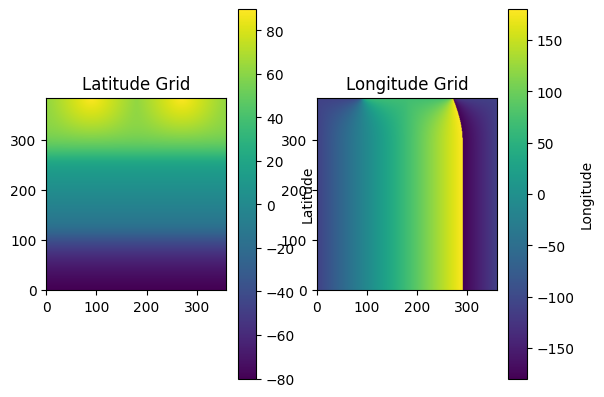

In [6]:
# Plot plat and plon to visualize the grid

plt.subplot(1, 2, 1)
plt.imshow(plat, origin="lower")
plt.colorbar(label="Latitude")
plt.title("Latitude Grid")

plt.subplot(1, 2, 2)
plt.imshow(plon, origin="lower")
plt.colorbar(label="Longitude")
plt.title("Longitude Grid")

plt.show()

In [7]:
print(np.max(plat), np.min(plat), np.max(plon), np.min(plon))

89.75749503829726 -80.11491140591812 179.9889159673213 -179.9967955192592


In [8]:
ds

<xarray.Dataset> Size: 12MB
Dimensions:   (time: 1, y: 385, x: 360, nv: 4)
Coordinates:
  * time      (time) object 8B 2010-01-17 00:00:00
    plat      (y, x) float64 1MB ...
    plon      (y, x) float64 1MB ...
Dimensions without coordinates: y, x, nv
Data variables:
    sst       (time, y, x) float32 554kB ...
    lat_bnds  (nv, y, x) float64 4MB ...
    lon_bnds  (nv, y, x) float64 4MB ...
Attributes: (3)

In [9]:
#ds = ds.assign_coords(lat=(["y", "x"], plat), lon=(["y", "x"], plon))
ds = ds.assign_coords(lat=(["y", "x"], plat), lon=(["y", "x"], plon))
ds

<xarray.Dataset> Size: 14MB
Dimensions:   (time: 1, y: 385, x: 360, nv: 4)
Coordinates:
  * time      (time) object 8B 2010-01-17 00:00:00
    plat      (y, x) float64 1MB ...
    plon      (y, x) float64 1MB ...
    lat       (y, x) float64 1MB -80.11 -80.11 -80.11 ... 62.59 62.35 62.11
    lon       (y, x) float64 1MB -109.5 -108.5 -107.5 ... -109.9 -109.9 -110.0
Dimensions without coordinates: y, x, nv
Data variables:
    sst       (time, y, x) float32 554kB ...
    lat_bnds  (nv, y, x) float64 4MB ...
    lon_bnds  (nv, y, x) float64 4MB ...
Attributes: (3)

In [10]:
# latitude and longitude variables, not dimensions
ds = ds.rename_vars({"lat": "latitude", "lon": "longitude"})
ds.latitude.attrs["standard_name"] = "latitude"
ds.longitude.attrs["standard_name"] = "longitude"
ds

<xarray.Dataset> Size: 14MB
Dimensions:    (time: 1, y: 385, x: 360, nv: 4)
Coordinates:
  * time       (time) object 8B 2010-01-17 00:00:00
    plat       (y, x) float64 1MB ...
    plon       (y, x) float64 1MB ...
    latitude   (y, x) float64 1MB -80.11 -80.11 -80.11 ... 62.59 62.35 62.11
    longitude  (y, x) float64 1MB -109.5 -108.5 -107.5 ... -109.9 -109.9 -110.0
Dimensions without coordinates: y, x, nv
Data variables:
    sst        (time, y, x) float32 554kB ...
    lat_bnds   (nv, y, x) float64 4MB ...
    lon_bnds   (nv, y, x) float64 4MB ...
Attributes: (3)

In [11]:
# Center the data
ds.coords["longitude"] = (ds.coords["longitude"] + 180) % 360 - 180

In [12]:
print(
    "Percentage of nan values for sst: {0:.05f}".format(
        np.isnan(ds.sst.to_numpy()).sum() / ds.sst.size
    )
)

Percentage of nan values for sst: 0.37440


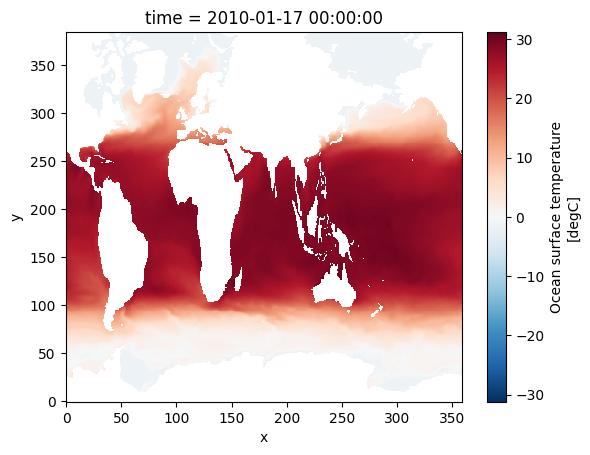

In [13]:
# Plot sea surface temperature on tripolar grid naively, using x and y
ds.sst.isel(time=0).plot()

When we plot using x and y, it looks like the North pole is missing, but this is just due to the tripolar projection.  
This is where the two northern poles are, hence the singularities where the North edges of Russia and Canada are "glued together".

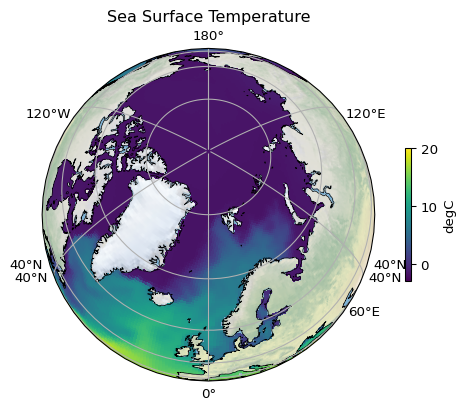

In [14]:
proj = ccrs.NearsidePerspective(
    central_longitude=0.0, central_latitude=80.0, satellite_height=3e6
)
fig, ax = plt.subplots(1, figsize=(8, 4.5), dpi=96, subplot_kw={"projection": proj})

# A temperature map
pm0 = ax.pcolormesh(
    plon,
    plat,
    ds.sst[0, :, :],
    vmin=-3,
    vmax=20,
    cmap="viridis",
    transform=ccrs.PlateCarree(),
    shading="auto",
    rasterized=True,
)


# Add coastlines and the lat-lon grid
ax.coastlines(resolution="50m", color="black", linewidth=0.5)
ax.stock_img()
gl = ax.gridlines(ylocs=range(15, 76, 15), draw_labels=True)
gl.ylocator = mpl.ticker.FixedLocator([40, 50, 60, 70, 80])

plt.colorbar(pm0, fraction=0.2, shrink=0.4, label="degC")

ax.set_title("Sea Surface Temperature")
plt.show()

In [15]:
del ds

# 3. Load regridded dataset with PlateCarree grid

This data can be regridded to PlateCarree very easily using netcdf inbuilt functions in the terminal:  
brew install netcdf  
brew install nco  
### Append (-A) the variables plat and plon from grid.nc into blom_sst.nc:  
ncks -A -v plat,plon ./data/grid/grid.nc ./data/model/JRAOC20TRNRPv2_hm_sst_2010-01.nc  
### Bilinear regridding:  
cdo -O remapbil,global_1 blom_sst.nc blom_sst_1x1d.nc  
cdo -O remapbil,global_1 ./data/model/JRAOC20TRNRPv2_hm_sst_2010-01.nc blom_sst_1x1d.nc  
### Conservative regridding also needs corner coordinates:  
ncks -A -v plon,plat,pclon,pclat ./data/grid/grid.nc ./data/model/JRAOC20TRNRPv2_hm_sst_2010-01.nc
#### And we need to assign standard names to the corners: 
ncdump -h ./data/model/JRAOC20TRNRPv2_hm_sst_2010-01.nc
#### Remame corners as standard bounds 
ncrename -v pclat,lat_bnds -v pclon,lon_bnds ./data/model/JRAOC20TRNRPv2_hm_sst_2010-01.nc


###  txt file for grid 
cdo setgrid,./data/grid/grid.txt ./data/model/JRAOC20TRNRPv2_hm_sst_2010-01.nc model_with_grid.nc


cdo griddes ./data/grid/grid.nc > grid_definition.txt
cdo setgrid,grid_definition.txt ./data/model/JRAOC20TRNRPv2_hm_sst_2010-01.nc model_with_grid.nc
cdo -O remapcon,global_1 model_with_grid.nc blom_sst_1x1d_conservative.nc
#### failed

ncks -A -v plon,plat ./data/grid/grid.nc model_with_grid.nc

ncatted -a bounds,plon,o,c,"lon_bnds" model_with_grid.nc
ncatted -a bounds,plat,o,c,"lat_bnds" model_with_grid.nc

ncatted -a bounds,plon,o,c,"lon_bnds" model_with_grid.nc
ncatted -a bounds,plat,o,c,"lat_bnds" model_with_grid.nc
ncdump -h model_with_grid.nc | grep -A 5 "plon"
cdo -O remapcon,global_1 model_with_grid.nc blom_sst_1x1d_conservative.nc



#### Then retry: 

cdo -O remapcon2,global_1 ./data/model/JRAOC20TRNRPv2_hm_sst_2010-01.nc blom_sst_1x1d_conservative.nc  

# Load conservatively regridded

In [16]:
con_dataset_path = (
    data_path / "data" / "model" / "JRAOC20TRNRPv2_hm_sst_2010-01_1x1d.nc"
)
dcon = xr.open_dataset(con_dataset_path)
dcon

<xarray.Dataset> Size: 264kB
Dimensions:  (time: 1, lon: 360, lat: 180)
Coordinates:
  * time     (time) object 8B 2010-01-17 00:00:00
  * lon      (lon) float64 3kB -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
  * lat      (lat) float64 1kB -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
Data variables:
    sst      (time, lat, lon) float32 259kB ...
Attributes: (6)

In [17]:
dcon = dcon.rename_dims({"lat": "latitude", "lon": "longitude"})
dcon.latitude.attrs["standard_name"] = "latitude"
dcon.longitude.attrs["standard_name"] = "longitude"
dcon[["longitude", "latitude"]].compute()
dcon = dcon.rename({"lon": "longitude", "lat": "latitude"})

/var/folders/_r/k7zwg4td0z54sgjlxsfx325m0000gn/T/ipykernel_78244/3669483257.py:5: UserWarning: rename 'lon' to 'longitude' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  dcon = dcon.rename({"lon": "longitude", "lat": "latitude"})
/var/folders/_r/k7zwg4td0z54sgjlxsfx325m0000gn/T/ipykernel_78244/3669483257.py:5: UserWarning: rename 'lat' to 'latitude' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  dcon = dcon.rename({"lon": "longitude", "lat": "latitude"})


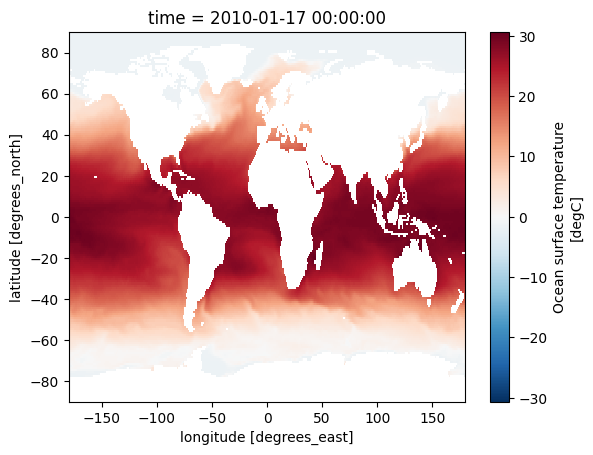

In [18]:
dcon.sst.isel(time=0).plot()

# Load regridded with bilinear

In [19]:
regridded_dataset_path = (
    data_path / "data" / "model" / "JRAOC20TRNRPv2_hm_sst_2010-01_1x1d.nc"
)
dr = xr.open_dataset(regridded_dataset_path)
dr

<xarray.Dataset> Size: 264kB
Dimensions:  (time: 1, lon: 360, lat: 180)
Coordinates:
  * time     (time) object 8B 2010-01-17 00:00:00
  * lon      (lon) float64 3kB -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
  * lat      (lat) float64 1kB -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
Data variables:
    sst      (time, lat, lon) float32 259kB ...
Attributes: (6)

In [20]:
dr = dr.rename_dims({"lat": "latitude", "lon": "longitude"})
dr.latitude.attrs["standard_name"] = "latitude"
dr.longitude.attrs["standard_name"] = "longitude"
dr[["longitude", "latitude"]].compute()
dr = dr.rename({"lon": "longitude", "lat": "latitude"})

/var/folders/_r/k7zwg4td0z54sgjlxsfx325m0000gn/T/ipykernel_78244/1876464242.py:5: UserWarning: rename 'lon' to 'longitude' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  dr = dr.rename({"lon": "longitude", "lat": "latitude"})
/var/folders/_r/k7zwg4td0z54sgjlxsfx325m0000gn/T/ipykernel_78244/1876464242.py:5: UserWarning: rename 'lat' to 'latitude' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  dr = dr.rename({"lon": "longitude", "lat": "latitude"})


In [21]:
regrid_diff = dr - dcon
regrid_diff

<xarray.Dataset> Size: 264kB
Dimensions:    (time: 1, longitude: 360, latitude: 180)
Coordinates:
  * time       (time) object 8B 2010-01-17 00:00:00
  * longitude  (longitude) float64 3kB -179.5 -178.5 -177.5 ... 178.5 179.5
  * latitude   (latitude) float64 1kB -89.5 -88.5 -87.5 -86.5 ... 87.5 88.5 89.5
Data variables:
    sst        (time, latitude, longitude) float32 259kB nan nan nan ... 0.0 0.0
Attributes: (6)

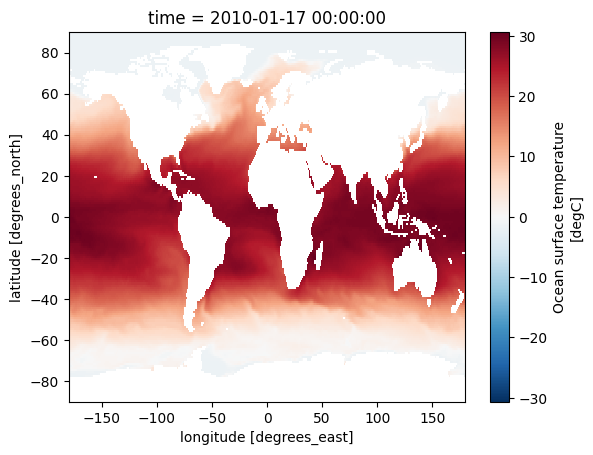

In [22]:
dr.sst.isel(time=0).plot()

In [36]:
dr

<xarray.Dataset> Size: 264kB
Dimensions:    (time: 1, longitude: 360, latitude: 180)
Coordinates:
  * time       (time) object 8B 2010-01-17 00:00:00
  * longitude  (longitude) float64 3kB -179.5 -178.5 -177.5 ... 178.5 179.5
  * latitude   (latitude) float64 1kB -89.5 -88.5 -87.5 -86.5 ... 87.5 88.5 89.5
Data variables:
    sst        (time, latitude, longitude) float32 259kB nan nan ... -1.747
Attributes: (6)

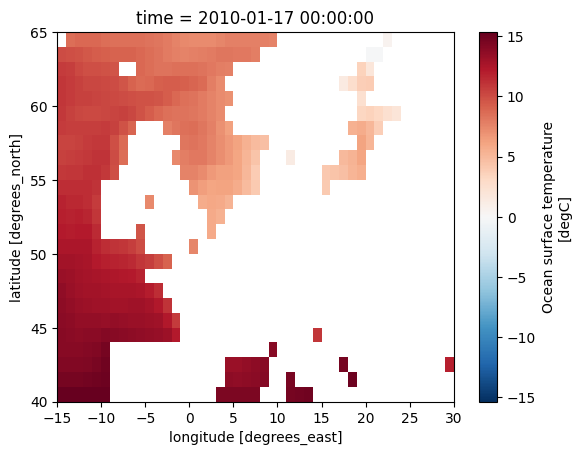

In [23]:
# Define zoomed-in region (adjust as needed)
lat_min, lat_max = 40, 65  # Example range
lon_min, lon_max = -15, 30

# Select only the region of interest
dr_zoomed = dr.sst.isel(time=0).sel(latitude=slice(lat_min, lat_max), longitude=slice(lon_min, lon_max))

# Plot the zoomed-in region
dr_zoomed.plot()

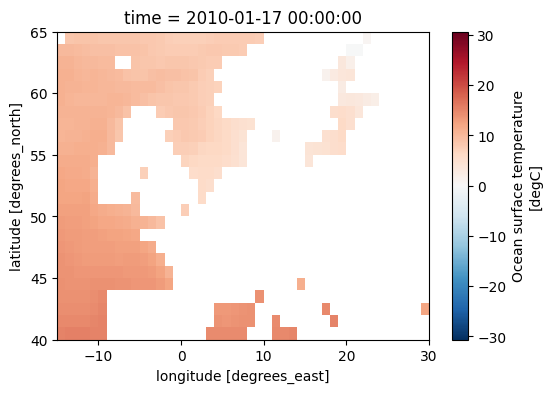

In [24]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(6, 4))
p = dr.sst.isel(time=0).plot(ax=ax)

# Set zoom limits
ax.set_xlim(lon_min, lon_max)
ax.set_ylim(lat_min, lat_max)

plt.show()

In [25]:
print(
    "Percentage of nan values for sst: {0:.05f}".format(
        np.isnan(dr.sst.to_numpy()).sum() / dr.sst.size
    )
)

Percentage of nan values for sst: 0.36619


From the above cell we see that the percentage of nan cells has gone down when regridding to the PlateCarree grid.  
Naively, one would think that this indicates a liberal policy of how many vertices (min_vertices) are needed to assign value to a cell, and that for the purposes of this notebook, this is good because it keeps as much information as possible.  
On second thought though, could this be due to the nature of where cells are located, and mean that we do not know how the amount of nan covered **area** has changed? 

Define an ocean mask using the nan values of SST:

In [26]:
ocean_mask = ~dr.sst.isel(time=0).isnull()  # Mask land as False, ocean as True

## 4. Define target grid: DGGS

In [27]:
nside = 256  # Each side of the original 12 faces in Healpix is divided into nside parts
healpy_grid_level = int(np.log2(nside))  # Healpix level
number_of_cells = 12 * nside**2  # The resulting total number of cells

min_vertices = 1  # Minimum number of vertices for a valid transcription for regridding.
# 1 is the most liberal, meaning that only one is needed

print("nside:", nside)
print("Level:", healpy_grid_level)
print("Number of cells:", number_of_cells)

nside: 256
Level: 8
Number of cells: 786432


# 5. Regrid from PlateCarree to DGGS

In [28]:
# Convert to 1D arrays of coordinates
lon, lat = xr.broadcast(dr.longitude, dr.latitude)
lat

<xarray.DataArray 'latitude' (longitude: 360, latitude: 180)> Size: 518kB
-89.5 -88.5 -87.5 -86.5 -85.5 -84.5 -83.5 ... 83.5 84.5 85.5 86.5 87.5 88.5 89.5
Coordinates:
  * latitude   (latitude) float64 1kB -89.5 -88.5 -87.5 -86.5 ... 87.5 88.5 89.5
  * longitude  (longitude) float64 3kB -179.5 -178.5 -177.5 ... 178.5 179.5
Attributes: (4)

In [29]:
# Define the target Healpix grid
grid = HealpyGridInfo(level=healpy_grid_level)
target_grid = (
    grid.target_grid(dr)
    .pipe(center_longitude, 0)
    .drop_attrs(deep=False)
    .dggs.decode({"grid_name": "healpix", "nside": nside, "indexing_scheme": "nested"})
)

In [30]:
# Create the regridder: Compute interpolation weights for regridding diff data
regridder = HealpyRegridder(
    dr[["longitude", "latitude"]].compute(),
    target_grid,
    method="bilinear",
    interpolation_kwargs={"mask": ocean_mask, "min_vertices": min_vertices},
)
print(regridder)

HealpyRegridder(method='bilinear', interpolation_kwargs={'mask': <xarray.DataArray 'sst' (latitude: 180, longitude: 360)> Size: 65kB
False False False False False False False ... True True True True True True True
Coordinates:
    time       object 8B 2010-01-17 00:00:00
  * longitude  (longitude) float64 3kB -179.5 -178.5 -177.5 ... 178.5 179.5
  * latitude   (latitude) float64 1kB -89.5 -88.5 -87.5 -86.5 ... 87.5 88.5 89.5
Attributes: (3), 'min_vertices': 1})


/Users/even/miniforge3/envs/esmpy-env/lib/python3.11/site-packages/xarray_healpy/interpolation/mask.py:22: RuntimeWarning: invalid value encountered in divide
  return masked_weights / np.sum(masked_weights, axis=-1)[:, None]


In [31]:
regridded = regridder.regrid_ds(dr).pipe(xdggs.decode)

In [32]:
ds_regridded = regridded.sst.compute().squeeze()

In [37]:
ds_regridded.dggs.explore()

Map(custom_attribution='', layers=(SolidPolygonLayer(filled=True, get_fill_color=arro3.core.ChunkedArray<Fixed…

# Save the transformed data to zarr

In [34]:
url = f"./SST-healpix-lvl-{healpy_grid_level}.zarr"
print("url:", url)
ds_regridded.to_zarr(url, mode="w") 

url: ./SST-healpix-lvl-8.zarr


/Users/even/miniforge3/envs/esmpy-env/lib/python3.11/site-packages/zarr/api/asynchronous.py:203: UserWarning: Consolidated metadata is currently not part in the Zarr format 3 specification. It may not be supported by other zarr implementations and may change in the future.
  warnings.warn(
